In [8]:
!pip install pytube

In [9]:
import keras
from keras.preprocessing import image
import numpy as np
import pandas as pd
from keras.models import load_model
import cv2
import json
import pytube


In [4]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
#load the model
model=load_model('/content/gdrive/MyDrive/model6.h5')

In [11]:
img_high=220
img_width=220
frame_num_video=10

In [12]:
# get the links of youtube videos from csv file

df=[]
nick_name="CSCE636Spring2021-Farry-6"
label="smoking"
probs=[]
times=[]
 
url="https://www.youtube.com/watch?v=w5c6yvZEQ7M"
yt= pytube.YouTube(url)
vid_id=yt.video_id
yt= yt.streams.first()
video=yt.download()

# capturing the video from the given path
cap = cv2.VideoCapture(video)  
total_frames = int(cap.get(7))


#split youtube video to video clips of 2s
clip_len =2
frames=[]
frame_rate = cap.get(5) # frames per second 
vid_len = int(total_frames/frame_rate) # video time  in seconds
intervals = int(vid_len/clip_len) #how many video clips
print(intervals,vid_id)
frame_per_interval = total_frames //intervals #how many frames are in each clips
frame_distance = frame_per_interval//10  # skip some frames 

frame_count = 0   # This variable keeps count of the total frames
clip_count = 1
frame_count_all=0
frame_time=[]

for i in range (total_frames): #iterating over all the frames of the video.
      ret, frame = cap.read()
      if ret ==False:  # Checking if the frame is missing, and if missing, we take the previous frame
          frame = f_prev
      elif ret==True:
          f_prev =frame

      frame_count_all +=1    
      frame_count +=1
    
      if frame_count ==frame_distance:   
          frame_count = 0
          frame=cv2.resize(frame,(img_high,img_width),interpolation=cv2.INTER_AREA)
          frames.append(frame)
          frame_time.append(frame_count_all*(1/frame_rate))
          
        # when we reach to video clip length save the frames
      if i == ((clip_count*frame_per_interval)-1):
          inpt = np.array(frames)
          inpt = inpt.astype('float32')
          inpt -= np.mean(inpt)
          inpt /=np.max(inpt)
          
          frames = []
          #  I just keep 10 frames to have the format of the model
          inpt_shape = np.zeros((1, 10, img_high, img_width, 3))
          inpt_shape[0][:][:][:][:] = inpt[:10][:][:][:]
          p = model.predict(inpt_shape)
          prob = p[:][0][0]
       
          
          start_time=round(frame_time[0],2)
          end_time=round(frame_time[-1],2)
          min_s, sec_s = divmod(frame_time[0], 60)
          start_time2=str("%d:%02d" % (min_s, sec_s) ) #Starting time of the interval
          min_e, sec_e = divmod(frame_time[-1],60) 
          end_time2 = str("%d:%02d" % (min_e, sec_e) )  # Ending time of the interval 
          probs.append(prob)
          times.append(start_time)
          frame_time=[]
     
          if prob>=0.60:
              print(prob,start_time,end_time,start_time2,end_time2)
              data= {"videoId":vid_id,
                      "type":"segment",
                      "startTime":float(start_time),
                      "endTime":float(end_time),
                      "observer":nick_name,
                      "isHuman":False,
                      "confirmedBySomeone": False,
                      "rejectedBySomeone": False,"observation":{"label": label,"labelConfidence": 0.85}}
              df.append(data)
              
          clip_count += 1 #next clip
          
          if cv2.waitKey(1) & 0xFF == ord('q'):
              break
cap.release()
cv2.destroyAllWindows()


40 w5c6yvZEQ7M
[0.62955576] 22.22 24.02 0:22 0:24
[0.6088065] 34.23 36.04 0:34 0:36
[0.60178965] 44.24 46.05 0:44 0:46
[0.66320246] 72.27 74.07 1:12 1:14


No handles with labels found to put in legend.


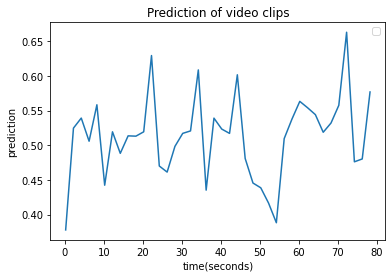

In [13]:
import matplotlib.pyplot as plt 

plt.plot(times, probs)
plt.title('Prediction of video clips')
plt.ylabel('prediction')
plt.xlabel('time(seconds)')
plt.legend()

In [14]:
import os
json_dir='/content/gdrive/MyDrive'
filename="CSCE636Spring2021-Farry-6.json"
with open(os.path.join(json_dir,filename), 'w',encoding='utf-8') as f:
     json.dump(df, f,ensure_ascii=False, indent=4)
   